# Import and install libraries

In [1]:
!pip install mxnet
!pip install gluonnlp==0.8.0
!pip install tqdm pandas
!pip install sentencepiece
!pip install transformers
!pip install torch>=1.8.1

!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 16.9 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.8.0-py3-none-any.whl size=292696 sha256=88557f37b17ebea7a29768c2364ddeb159c51e4c1180170052f2930ab7e4f2e2
  Stored in directory: /root/.cache/pip/wheels/2d/cc/dc/7ec84dced25f738b8be400101abb67e4b50c905090a51017e4
Successfully built gluonnlp
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

# Import pre-tokenized data

In [2]:
from google.colab import drive
drive.mount('./gdrive')

Mounted at ./gdrive


In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

/usr/local/lib/python3.10/dist-packages/mxnet/optimizer/optimizer.py:163: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  warnings.warn('WARNING: New optimizer %s.%s is overriding '


In [4]:
# Torch GPU 설정
device_type = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_type)

In [11]:
# import data
#'gdrive/MyDrive/data/news/tokenized_train_data.xlsx
token_df = pd.read_excel('gdrive/MyDrive/final DP/tokenized_train_data.xlsx', index_col = 0)
token_df.head()

,Date,User,Summary,Label,Type,Topic,clean_text
0,2020-03-24 00:00:00,tkadnjs4770,"#장병완 의원, ‘#청년에게_용기를’ #청년정책 공약 발표\n\n“주거와 취업은 청...",1,트위터,청년정책,장병완 의원 청년 용기 청년 정책 공약 발표 주거 취업 청년 미래 설계 기본 토대 ...
1,2019-09-15 00:00:00,FairSociety88,"이재명이 있잖아! \n\n최초의 청년배당 청년정책들, 이 모든 정책을 봐! \n\...",0,트위터,청년정책,이재명 최초 청년 배당 청년 정책 정책 이 재명 청년 지원 정치 인 재명 포함 청년...
2,2019-12-19 00:00:00,TheKoreanOfWill,* #2019년12월19일 의 #오늘의이야기1\n\n: #국무조정실 #청년정책추진단...,1,트위터,청년정책,오늘 이야기 국무 조정 실 청년 정책 주관 청년 기본법 토론회 참석 청년 기본법 기...
3,2021-05-08 00:00:00,OhmyNews_Korea,'청년'으로 도마 위 오른 이재명과 오세훈 #이재명 #청년정책 #서울시 #오세훈 #...,1,트위터,청년정책,청년 도마 위 이재명 오세훈 이재명 청년 정책 서울시 오세훈 경기도 박정훈 기자
4,2019-05-02 00:00:00,DikesEye,국무총리실을 청년정책 콘트롤타워로…청년정책조정위 설치 http://yna.kr/AK...,1,트위터,청년정책,국무총리실 청년 정책 콘트롤 타워 청년 정책 조정 위 설치


<Axes: >

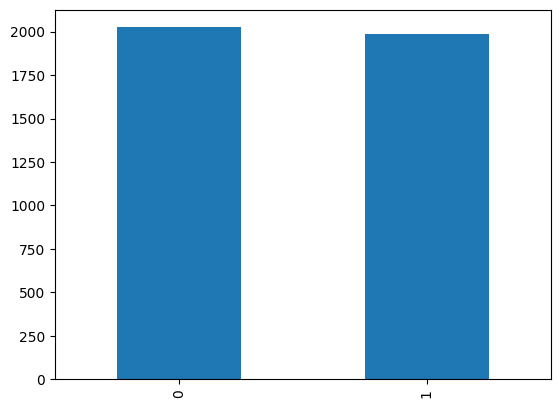

In [12]:
token_df.at[1516, 'Label'] = 0

token_df['Label'].value_counts().plot(kind='bar')

In [13]:
# BERTDataset prep
data_list = []

for review, label in zip(token_df['clean_text'], token_df['Label']):
  data = []
  data.append(review)
  data.append(label)
  data_list.append(data)

len(data_list)

data_list[:5]

[['장병완 의원 청년 용기 청년 정책 공약 발표 주거 취업 청년 미래 설계 기본 토대 학업 자립 전환 시기 씩 수 청년 세대 부담 정책 민생',
  1],
 ['이재명 최초 청년 배당 청년 정책 정책 이 재명 청년 지원 정치 인 재명 포함 청년 노래 완전 새 꺼 똥파리 말 선동 눈 제발', 0],
 ['오늘 이야기 국무 조정 실 청년 정책 주관 청년 기본법 토론회 참석 청년 기본법 기본 법안 장 개조 시행령 개 내외 조 청년 세 청년 정책 경과보고 이무기 마음 시 섬 리',
  1],
 ['청년 도마 위 이재명 오세훈 이재명 청년 정책 서울시 오세훈 경기도 박정훈 기자', 1],
 ['국무총리실 청년 정책 콘트롤 타워 청년 정책 조정 위 설치', 1]]

In [14]:
# Train, test split

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data_list, test_size = 0.3, shuffle = True, random_state = 23)

print('훈련용 리뷰의 개수 : ', len(train_data))
print('테스트용 리뷰의 개수 : ', len(test_data))

훈련용 리뷰의 개수 :  2807
테스트용 리뷰의 개수 :  1203


In [15]:
train_data[:5]

[['서울 청년 정책 수기 공모 이벤트 수 상작 걸음 데 도움 청년 수당 우수 내용 청년 행복 프로젝트 청년 정보통 수기 공모전 일상 글 공감 글 청년 수당',
  1],
 ['간호 정책 선 포식 참여 전남 얘 생각 가까이 얼굴 번 간호 정책 선 포식 즈음 발식 간호법 제정 마음 진심 수 눈물 간호법 제정 분 감사 간호 정책 선 포식 한 강 공원 강 오랜만 서울 거 건물 감탄 머 촌놈 한강 공원 스타 영상 뻔 학교 전 포토 이즘 뻔 서울 끗',
  1],
 ['이분 집사 전세', 0],
 ['청년 정책 복지 생활 편 관심 부탁 출처 청년 정책 청년 정책 공모전 공모전 복지 생활 편 청년 정책 홍보', 1],
 ['우려 현실 전 호대 정원 증원 관련 글 적 이 게 간호 사람 생각 계속 증원 병원 사람 현실 제도 문제 병원 시스템 차이 천차만별 때문 이 게 정책 증원 간호 인력 증원 간호 대생 학사 특별 편입 신설 검토 내용 현장 사람 이유 기사 중 연간 천 명 간호사 배출 거 현장 분위기 의견 검토 현장 검토 현장 사람 설문 조사 피부 변화 걸 현장 말 채 기사 화 난 수 결과 기대 효과 간호법 제정 병원 참여 시위 기사 날 작년 게 정도 미래 고민 노력 뭔가 거 기대감 힘 기사 사진 현장 간호사 목소리 묵 살 채 말 현장 표정 무표정 전쟁터 목소리 코로나 중환자 교육 인력 환자 간극 해결 코로나 환자 계속 케어 데 수당 팬데 믹 시절 레벨 디 수 정확 정도 듯이 간호사 수당 점 전선 구역 사람 해당 만 수당 점 게 화 지금 사람 보상 삶 수 연차 삶 물 밥 포기 현실 규정 포함 밥 흡입 보호 장치 선별 주취 현실 말 끝 기본 일기',
  0]]

# KoBERT tokenizer, model

In [16]:
#@title BERTSentenceTransform 수정

class BERTSentenceTransform:
    r"""BERT style data transformation.

    Parameters
    ----------
    tokenizer : BERTTokenizer.
        Tokenizer for the sentences.
    max_seq_length : int.
        Maximum sequence length of the sentences.
    pad : bool, default True
        Whether to pad the sentences to maximum length.
    pair : bool, default True
        Whether to transform sentences or sentence pairs.
    """

    def __init__(self, tokenizer, max_seq_length,vocab, pad=True, pair=True):
        self._tokenizer = tokenizer
        self._max_seq_length = max_seq_length
        self._pad = pad
        self._pair = pair
        self._vocab = vocab

    def __call__(self, line):
        """Perform transformation for sequence pairs or single sequences.

        The transformation is processed in the following steps:
        - tokenize the input sequences
        - insert [CLS], [SEP] as necessary
        - generate type ids to indicate whether a token belongs to the first
        sequence or the second sequence.
        - generate valid length

        For sequence pairs, the input is a tuple of 2 strings:
        text_a, text_b.

        Inputs:
            text_a: 'is this jacksonville ?'
            text_b: 'no it is not'
        Tokenization:
            text_a: 'is this jack ##son ##ville ?'
            text_b: 'no it is not .'
        Processed:
            tokens: '[CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]'
            type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
            valid_length: 14

        For single sequences, the input is a tuple of single string:
        text_a.

        Inputs:
            text_a: 'the dog is hairy .'
        Tokenization:
            text_a: 'the dog is hairy .'
        Processed:
            text_a: '[CLS] the dog is hairy . [SEP]'
            type_ids: 0     0   0   0  0     0 0
            valid_length: 7

        Parameters
        ----------
        line: tuple of str
            Input strings. For sequence pairs, the input is a tuple of 2 strings:
            (text_a, text_b). For single sequences, the input is a tuple of single
            string: (text_a,).

        Returns
        -------
        np.array: input token ids in 'int32', shape (batch_size, seq_length)
        np.array: valid length in 'int32', shape (batch_size,)
        np.array: input token type ids in 'int32', shape (batch_size, seq_length)

        """

        # convert to unicode
        text_a = line[0]
        if self._pair:
            assert len(line) == 2
            text_b = line[1]

        tokens_a = self._tokenizer.tokenize(text_a)
        tokens_b = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            self._truncate_seq_pair(tokens_a, tokens_b,
                                    self._max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]

        # The embedding vectors for `type=0` and `type=1` were learned during
        # pre-training and are added to the wordpiece embedding vector
        # (and position vector). This is not *strictly* necessary since
        # the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.

        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        #vocab = self._tokenizer.vocab
        vocab = self._vocab
        tokens = []
        tokens.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)

        # The valid length of sentences. Only real  tokens are attended to.
        valid_length = len(input_ids)

        if self._pad:
            # Zero-pad up to the sequence length.
            padding_length = self._max_seq_length - valid_length
            # use padding tokens for the rest
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            segment_ids.extend([0] * padding_length)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'),\
            np.array(segment_ids, dtype='int32')

In [17]:
import gluonnlp as nlp
from transformers import BertModel
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

from kobert_tokenizer import KoBERTTokenizer

class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        #transform = nlp.data.BERTSentenceTransform(
        #    tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [18]:
# kobert 공식 git에 있는 get_kobert_model 선언
def get_kobert_model(model_path, vocab_file, ctx="cpu"):
    bertmodel = BertModel.from_pretrained(model_path)
    device = torch.device(ctx)
    bertmodel.to(device)
    bertmodel.eval()
    vocab_b_obj = nlp.vocab.BERTVocab.from_sentencepiece(vocab_file,
                                                         padding_token='[PAD]')
    return bertmodel, vocab_b_obj

In [19]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel, vocab = get_kobert_model('skt/kobert-base-v1',tokenizer.vocab_file)
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower = False)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [33]:
#parameter

max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [21]:
train_dataset = BERTDataset(train_data, 0, 1, tokenizer, vocab, max_len, True, False)
test_dataset = BERTDataset(test_data, 0, 1, tokenizer, vocab, max_len, True, False)

In [22]:
train_dataset.labels[:3]

[1, 1, 0]

In [23]:
test_dataset.sentences[:3]

[(array([   2, 4485, 4119, 1586, 4485, 4119, 3056, 4485, 4491, 5341, 1656,
         4485, 2132,  517, 7729, 4485, 3714, 1050, 3108, 1283,    3,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32),
  array(21, dtype=int32),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        dtype=int32)),
 (array([   2,  517, 5370, 6557,  777,  517, 7095, 3886, 2889,  835, 4099,
         2468, 4431, 4485, 4119,  517, 7630, 2870, 3380, 3380,  517, 6719,
         1280, 6608, 4092, 5712, 4119, 3617, 3574, 6703, 7993,  517, 7673,
         6441, 4485, 4119,  517, 7630, 1280, 6608, 29

In [24]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, num_workers = 5)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, num_workers = 5)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


KoBERT model

In [25]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = 2,   # 1: pos, 0: neg
                 dr_rate = None,
                 params = None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p = dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict = False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)


In [26]:
model = BERTClassifier(bertmodel,  dr_rate = 0.5).to(device)

optimizer and schedule

In [27]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

# 최적화해야 할 parameter를 optimizer에게 알려야 함
optimizer = AdamW(optimizer_grouped_parameters, lr = learning_rate)
loss_fn = nn.CrossEntropyLoss() # 다중분류를 위한 loss function

t_total = len(train_loader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = warmup_step, num_training_steps = t_total)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [28]:
#calculate accuracy

def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

train_loader

# Train

In [29]:
# train_history = []
# test_history = []
# loss_history = []

# for e in range(num_epochs):
#     train_acc = 0.0
#     test_acc = 0.0

#     model.train()
#     for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_loader)):
#         optimizer.zero_grad()
#         token_ids = token_ids.long().to(device)
#         segment_ids = segment_ids.long().to(device)
#         valid_length= valid_length
#         label = label.long().to(device)
#         out = model(token_ids, valid_length, segment_ids)

#         # print(label.shape, out.shape)
#         loss = loss_fn(out, label)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
#         optimizer.step()
#         scheduler.step()  # Update learning rate schedule
#         train_acc += calc_accuracy(out, label)
#         if batch_id % log_interval == 0:
#             print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
#             train_history.append(train_acc / (batch_id+1))
#             loss_history.append(loss.data.cpu().numpy())
#     print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

#     model.eval()
#     for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_loader)):
#         token_ids = token_ids.long().to(device)
#         segment_ids = segment_ids.long().to(device)
#         valid_length = valid_length
#         label = label.long().to(device)
#         out = model(token_ids, valid_length, segment_ids)
#         test_acc += calc_accuracy(out, label)
#     print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
#     test_history.append(test_acc / (batch_id+1))


In [34]:
for e in range(num_epochs):

    train_acc = 0.0
    test_acc = 0.0

    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(train_loader), total=len(train_loader)):
        optimizer.zero_grad()

        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule

        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(test_loader), total=len(test_loader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

  0%|          | 0/44 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 0.34454768896102905 train acc 0.890625
epoch 1 train acc 0.9135911673553718


  0%|          | 0/19 [00:00<?, ?it/s]

epoch 1 test acc 0.7921020381836946


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.35674527287483215 train acc 0.875
epoch 2 train acc 0.9148372933884297


  0%|          | 0/19 [00:00<?, ?it/s]

epoch 2 test acc 0.7546762125902994


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.5338285565376282 train acc 0.8125
epoch 3 train acc 0.9180333161157024


  0%|          | 0/19 [00:00<?, ?it/s]

epoch 3 test acc 0.7886029411764707


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.31192469596862793 train acc 0.890625
epoch 4 train acc 0.9209904442148761


  0%|          | 0/19 [00:00<?, ?it/s]

epoch 4 test acc 0.7916827915376677


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.31397780776023865 train acc 0.90625
epoch 5 train acc 0.9045971074380166


  0%|          | 0/19 [00:00<?, ?it/s]

epoch 5 test acc 0.7501612487100103


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.5280052423477173 train acc 0.78125
epoch 6 train acc 0.927266270661157


  0%|          | 0/19 [00:00<?, ?it/s]

epoch 6 test acc 0.7824432404540764


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.1664525419473648 train acc 0.9375
epoch 7 train acc 0.9527698863636364


  0%|          | 0/19 [00:00<?, ?it/s]

epoch 7 test acc 0.7886029411764707


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.09932172298431396 train acc 0.984375
epoch 8 train acc 0.9786931818181818


  0%|          | 0/19 [00:00<?, ?it/s]

epoch 8 test acc 0.7896349329205367


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.08659196645021439 train acc 0.984375
epoch 9 train acc 0.9904119318181818


  0%|          | 0/19 [00:00<?, ?it/s]

epoch 9 test acc 0.7921020381836946


  0%|          | 0/44 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.081507109105587 train acc 0.984375
epoch 10 train acc 0.9886363636363636


  0%|          | 0/19 [00:00<?, ?it/s]

epoch 10 test acc 0.7886029411764707


# Save model

In [32]:
PATH = 'gdrive/MyDrive/공모전/2023_News/Yen'
torch.save(model.state_dict(), PATH + 'naver_shopping.pt')  # 모델 객체의 state_dict 저장
# torch.save({
#     'model': model.state_dict(),
#     'optimizer': optimizer.state_dict()
# }, PATH + 'all.tar')  # 여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch, loss 값 등 일반 scalar값 저장 가능

RuntimeError: ignored

# Input test

In [ ]:
def predict(predict_sentence):

    data = [predict_sentence, 0]
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_loader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_loader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("0")
            else:
                test_eval.append("1")

        print(test_eval[0])

https://github.com/ChangZero/koBERT-finetuning-demo/blob/main/kobert_colab.ipynb